# State-space models: The Kalman Filter and Smoother
---

In this notebook, we will illustrate the Kalman Filter and Smoothing algorithms by looking at a 2-D tracking over space example and a 1-D tracking over time example.

In [1]:
#Some libraries that we will be using.
from __future__ import print_function, division
import numpy as np
from scipy.stats import multivariate_normal
from IPython import display
import time
import math

#Configure the matplotlib backend as plotting inline
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#Enables latex
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':'20'})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

---

## Inference in LG-SSMs

We assume a LG-SSM (Linear Gaussian State Space Model) of the following form:

$$
\mathbf{z}_{t} = \mathbf{A}_{t}\mathbf{z}_{t-1} + \mathbf{B}_{t}\mathbf{u}_{t} + \boldsymbol{\epsilon}_{t}\\
\mathbf{y}_{t} = \mathbf{C}_{t}\mathbf{z}_{t} + \mathbf{D}_{t}\mathbf{u}_{t} + \boldsymbol{\delta}_{t}
\newcommand\given[1][]{\:#1\vert\:} 
$$

where the first equation is known as the \textit{transition model} with \textit{system noise} $\boldsymbol{\epsilon}_{t} \sim \mathcal{N}(0,\mathbf{Q}_{t})$ and the second is the \textit{observation model} with \textit{observation noise} $\boldsymbol{\delta}_{t} \sim \mathcal{N}(0,\mathbf{R}_{t})$. The parameters $\boldsymbol{\theta}_{t} = (\mathbf{A}_{t},\mathbf{B}_{t},\mathbf{C}_{t},\mathbf{D}_{t},\mathbf{Q}_{t},\mathbf{R}_{t})$ can be independent of time, which is the case in these examples though time varying parameters may also be used without changing the code too much.

The two cases for inference in LG-SSMs  that we will consider are the \textit{online} case of \textbf{Kalman Filtering} (which is similar to the \textit{forwards} algorithm for HMMs) and the \textit{offline} case of \textbf{Kalman Smoothing} (\textit{forwards-backwards} algorithm for HMMs). 

---
### 1. Kalman Filter
---

The goal of Kalman filtering is to obtain the marginal posterior $p(\mathbf{z}_{t}\given{\mathbf{y}_{1:t},\mathbf{u}_{1:t}}) = \mathcal{N}(\mathbf{z}_{t}\given{\boldsymbol{\mu}_{t},\boldsymbol{\Sigma}_{t}})$ where $p(\mathbf{y}_{1:t}) = p(\mathbf{y}_{1},...,\mathbf{y}_{t})$ (the same applies for $\mathbf{u}_{1:t}$). This is done in two steps:

\begin{itemize}
\item \textbf{Prediction step} - In this step, we predict $\mathbf{z}_{t}$ based on $\mathbf{y}_{1:t-1}$ and $\mathbf{u}_{1:t}$:

$$
p(\mathbf{z}_{t}\given{\mathbf{y}_{1:t-1},\mathbf{u}_{1:t}}) = \mathcal{N}(\mathbf{z}_{t}\given{\boldsymbol{\mu}_{t\given{t-1}},\boldsymbol{\Sigma}_{t\given{t-1}}})
$$

$$
\boldsymbol{\mu}_{t\given{t-1}} = \mathbf{A}_{t}\boldsymbol{\mu}_{t-1} + \mathbf{B}_{t}\mathbf{u}_{t}
$$

$$
\boldsymbol{\Sigma}_{t\given{t-1}} = \mathbf{A}_{t}\boldsymbol{\Sigma}_{t-1}\mathbf{A}_{t}^{T} + \mathbf{Q}_{t}
$$

\item \textbf{Measurement step} - Using the prediction $p(\mathbf{z}_{t}\given{\mathbf{y}_{1:t-1},\mathbf{u}_{1:t}})$, we can estimate our belief state $p(\mathbf{z}_{t}\given{\mathbf{y}_{1:t},\mathbf{u}_{1:t}})$ by incorporating the new observation $\mathbf{y}_{t}$ because:

$$
p(\mathbf{z}_{t}\given{\mathbf{y}_{t}, \mathbf{y}_{1:t-1}, \mathbf{u}_{1:t}}) \propto p(\mathbf{y}_{t}\given{\mathbf{z}_{t},\mathbf{u}_{t}})p(\mathbf{z}_{t}\given{\mathbf{y}_{1:t-1},\mathbf{u}_{1:t}})
$$

Therefore, this gives:

$$
p(\mathbf{z}_{t}\given{\mathbf{y}_{1:t},\mathbf{u}_{1:t}}) = \mathcal{N}(\mathbf{z}_{t}\given{\boldsymbol{\mu}_{t}, \boldsymbol{\Sigma}_{t}})
$$

$$
\boldsymbol{\mu}_{t} = \boldsymbol{\mu}_{t\given{t-1}} + \mathbf{K}_{t}\mathbf{r}_{t}
$$

$$
\boldsymbol{\Sigma}_{t} = (\mathbf{I}-\mathbf{K}_{t}\mathbf{C}_{t})\boldsymbol{\Sigma}_{t\given{t-1}}
$$

where $\mathbf{r}_{t}$ is known as the \textbf{residual} or \textbf{innovation}:
$$
\mathbf{r}_{t} \triangleq \mathbf{y}_{t} - \hat{\mathbf{y}}_{t}
$$

$$
\hat{\mathbf{y}_{t}} \triangleq \mathbb{E}[\mathbf{y}_{t}\given{\mathbf{y}_{1:t-1},\mathbf{u}_{1:t}}] = \mathbf{C}_{t}\boldsymbol{\mu}_{t\given{t-1}} + \mathbf{D}_{t}\mathbf{u}_{t}
$$

and $\mathbf{K}_{t}$ is the \textbf{Kalman gain matrix} given by:

$$
\mathbf{K}_{t} \triangleq \boldsymbol{\Sigma}_{t\given{t-1}}\mathbf{C}^{T}\mathbf{S}_{t}^{-1}
$$

where

$$
\mathbf{S}_{t} = \mathrm{cov}[\mathbf{r}_{t}\given{\mathbf{y}_{1:t-1},\mathbf{u}_{1:t}}] = \mathbf{C}_{t}\boldsymbol{\Sigma}_{t\given{t-1}}\mathbf{C}_{t}^{T} + \mathbf{R}_{t}
$$
\end{itemize}

The code below then involves calculating these quantities (specifically the prediction $\boldsymbol{\mu}_{t\given{t-1}}, \boldsymbol{\Sigma}_{t\given{t-1}}$ (green ellipse) and measurement $\boldsymbol{\mu}_{t},\boldsymbol{\Sigma}_{t}$ (blue ellipse)) and plotting the distributions defined by these parameters for each prediction and measurement step. 

In [2]:
def kalmanFilter(y, A, C, Q, R, init_m, init_V, plt_predict=False, u=0, B=0, D=0):
    """
        The Kalman Filter
        
        Args:
          (Mandatory)
            y[:,t] - the observations at time t
            A - system matrix
            C - observation matrix
            Q - system covariance
            R - observation covariance
            init_m - initial state mean
            init_V - initial state covariance
            
          (Optional)
            plt_predict - set to 'True' to allow plotting of the predicted 
            u - inputs up to time t
            B - input matrix
            D - feedforward matrix
        
        Returns:
            m[:,t] = E[z(:,t) | y(:,1:t), {u(:,1:t)}]
            V[:,:,t] = Cov[z(:,t) | y(:,1:t), {u(:,1:t)}]
            mpred[:,t] = E[z(:,t) | y(:,1:t-1), {u(:,1:t)}]
            Vpred[:,:,t] = Cov[z(:,t) | y(:,1:t-1), {u(:,1:t)}] 
            loglik = sum{t=1}^T log P(y(:,t)) 
    """
    
    os, T = y.shape   #Observations shape 
    ss = A.shape[0]   #State space size
    
    if u == 0:
        u = np.zeros((1,T))
    
    if B == 0:
        B = np.zeros((1,1))
    
    if D == 0:
        D = np.zeros((1,1))
    
    m = np.zeros((ss, T))
    mpred = np.zeros((ss, T))
    V = np.zeros((ss, ss, T))
    Vpred = np.zeros((ss, ss, T))
    
    loglik = 0
    for t in range(T):
        if t==0:
            prevm = init_m
            prevV = init_V
        else:
            prevm = m[:,t-1]
            prevV = V[:,:,t-1]
        
        m[:,t], V[:,:,t], LL, mpred[:,t], Vpred[:,:,t] = \
                            kalmanUpdate(A, C, Q, R, y[:,t], prevm, prevV, (t==0), u[:,t], B, D)
                
        loglik += LL 
    
    return m, V, loglik, mpred, Vpred
    
    
def kalmanUpdate(A, C, Q, R, y, m, V, initialSlice, u, B, D):
    """
        Performs one step of the predict-update cycle of the Kalman filter 
    """
    
    #Predict-step
    if initialSlice:
        mpred = m + np.dot(B, u)
        Vpred = V
    else:
        mpred = np.dot(A, m) + np.dot(B, u)
        Vpred = np.dot(np.dot(A, V),A.T) + Q
    
    e = y - np.dot(C, mpred) - np.dot(D, u)
    S = np.dot(np.dot(C, Vpred), C.T) + R
    Sinv = np.linalg.inv(S)
    ss = V.shape[0]
    K = np.dot(np.dot(Vpred,C.T),Sinv)
    
    #Update-step
    mnew = mpred + np.dot(K,e)
    Vnew = np.dot((np.eye(ss) - np.dot(K,C)),Vpred)
    
    #Log-likelihood
    loglik = gaussLogprob(e, np.zeros((e.shape[0],1)), S)
    
    return mnew, Vnew, loglik, mpred, Vpred
    
def gaussLogprob(X, mu, Sigma):
    """
        Calculates the log pdf of multivariate Gaussian
        
        Args:
            X - A data matrix where each column represents a different data vector
            mu - The mean vector
            Sigma - The covariance matrix
        
        Returns:
            loglik - The log-likelihood of parameters
    """
    
    K = x.shape[0]  #No. of dimensions
    
    if np.allclose(Sigma, np.diag(np.diag(Sigma))):   #Calc inverse differently for diagonal case to increase speed
        inv_Sigma = np.diag(1/np.diag(Sigma))
    else:
        inv_Sigma = np.linalg.inv(Sigma)
    
    logp = -0.5*np.einsum('ij,ji->i',np.dot((X-mu).T,inv_Sigma).T,X-mu)  #einsum makes things quicker
    logZ = (K/2)*np.log(2*math.pi) + 0.5*np.linalg.slogdet(Sigma)[1]
    loglik = logp - logZ                
    
    return loglik

def plotGaussianEllipse(ax, m, V, ellipsecolor, markercolor,label=None,t=None):
    """
        Plots an ellipse representing the covariance matrix of a Gaussian.
        
        Args:
            ax - The Axes object on which to plot the ellipses
            m - The centre of the ellipse
            V - Covariance matrix
            ellipsecolor - Ellipse color border colour
            markercolor - Centre marker colour
          (Optional)
            label - label for the plot containing this point
            t - point at which to add new data
    """
    
    s = 4.605  #90% confidence interval
    eigVals, eigVecs = np.linalg.eig(V)
        
    #Sort eigvalues to make sure that large eigval is first
    idx = eigVals.argsort()[::-1]
    eigVals = eigVals[idx]
    eigVecs = eigVecs[:,idx]
        
    #Add ellipse to axes
    border = patches.Arc(xy=m,width = 2*(s*eigVals[0])**0.5,height = 2*(s*eigVals[1])**0.5,
                        angle=np.degrees(np.arctan2(eigVecs[1,0],eigVecs[0,0])), \
                         linewidth=0.5, linestyle='--',color=ellipsecolor,fill=False, zorder=2)
    ax.add_patch(border)
    
    #Either plot points that are joined by a line or plot them individually
    if t != None:
        data = ax.lines[-1].get_data()
        if t >= len(data[0]):
            new_xdata = np.append(data[0],m[0])
            new_ydata = np.append(data[1],m[1])
            ax.lines[-1].set_data((new_xdata, new_ydata))
        else:
            data[0][t] = m[0]
            data[1][t] = m[1]
            ax.lines[-1].set_data((data[0],data[1]))        
    else:   
        ax.plot(m[0],m[1],'x-',ms=10,mew=2,c=markercolor,label=label)
    
def plotLine(ax, a, b, color):
    """
        Plots a line between two points
    """
    ax.plot([a[0], b[0]],[a[1], b[1]], color=color,linestyle='solid')

def ldsSample(A, C, Q, R, initmu, T):
    """
        Simulates a run of a linear dynamical system
    """
    ss = A.shape[0]
    os = C.shape[0]
    
    x = np.zeros((ss,T))
    y = np.zeros((os,T))
    
    x[:,0] = np.dot(A,initmu) + np.random.multivariate_normal(np.zeros(ss),Q)
    y[:,0] = np.dot(C,x[:,0]) + np.random.multivariate_normal(np.zeros(os),R)
    
    for t in range(1,T):
        x[:,t] = np.dot(A,x[:,t-1]) + np.random.multivariate_normal(np.zeros(ss),Q)
        y[:,t] = np.dot(C,x[:,t-1]) + np.random.multivariate_normal(np.zeros(os),R)
    
    return x,y
    

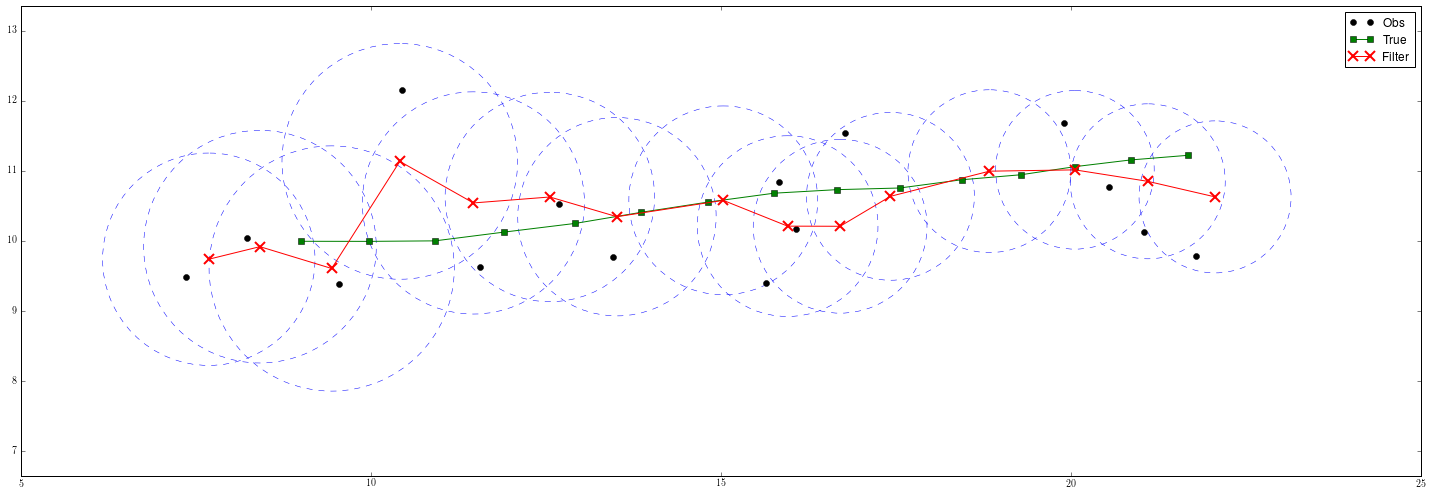

In [3]:
ss = 4    #Steady state space size
os = 2    #Observation size
A = np.array([[1, 0, 1, 0],[0, 1, 0, 1],[0, 0, 1, 0],[0, 0, 0, 1]])
C = np.array([[1, 0, 0, 0],[0, 1, 0, 0]])

Q = 0.001*np.eye(ss)
R = 1*np.eye(os)
initmu = np.array([8, 10, 1, 0])
initV = 1*np.eye(ss)

print("initmu: ",initmu.shape)
print("initV: ",initV.shape)
print("A: ",A.shape)
print("C: ",C.shape)
print("Q: ",Q.shape)
print("R: ",R.shape)

T = 15
x, y = ldsSample(A, C, Q, R, initmu, T)


input("Press enter to continue...")

mfilt, Vfilt, loglik, mpred, Vpred = kalmanFilter(y, A, C, Q, R, initmu, initV, plt_predict=True)


#Set up figure
fig = plt.figure()
fig.set_size_inches(20,7)
ax = fig.add_subplot(111)
plt.axis('equal')

#Plot observations and true data
ax.set_xlim(left=5,right=25)
ax.set_ylim(bottom=5,top=15)
ax.plot(y[0,:],y[1,:],'ko',label=r'Obs')  
ax.plot(x[0,:],x[1,:],'g-s',label=r'True')
ax.set_xlabel('$x_{1}$')
ax.set_ylabel('$x_{2}$')
fig.tight_layout()

runTillEnd = False

#Plot Kalman filter estimate
for t in range(mfilt.shape[1]):
    if not runTillEnd:
        if input("Press enter to continue (Predict). Type 'rte' to run simulation to end.") == "rte":
            runTillEnd = True
            
    display.clear_output(wait=True)
    
    #Plot prediction
    plotGaussianEllipse(ax, mpred[:,t], Vpred[:,:,t], \
                    ellipsecolor='green', markercolor='green')
    display.display(plt.gcf())
    
    if not runTillEnd:
        if input("Press enter to continue (Measurement). Type 'rte' to run simulation to end.") == "rte":
            runTillEnd = True
            
    display.clear_output(wait=True)
    
    #Remove last prediction ellipse
    del ax.patches[-1]
    del ax.lines[-1]
            
    #Plot update
    if t == 0:
        plotGaussianEllipse(ax, mfilt[:2,t],Vfilt[:2,:2,t],\
                    ellipsecolor='blue', markercolor='red',label=r'Filter')
        ax.legend()
    else:
        plotGaussianEllipse(ax, mfilt[:2,t],Vfilt[:2,:2,t],\
                    ellipsecolor='blue', markercolor='red',t=t)
    display.display(plt.gcf())

display.clear_output(wait=True)

##### Questions

- Can you explain why the ellipse gets smaller as we move towards the right mathematically?

---
### 1.2 Kalman Smoother
---

The Kalman smoothing algorithm is an extension of the Kalman filter whereby our estimate is based on both previous and future observations which will then significantly reduce our uncertainty.

After Kalman filtering has computed $p(\mathbf{z}_{T}\given{\mathbf{y}_{1:T}, \mathbf{u}_{1:T}})$, the smoothing algorithm is now applied whereby we work backwards to update our belief states for each time step. This gives the following equations:

$$
p(\mathbf{z}\given{\mathbf{y}_{1:T}}) = \mathcal{N}(\boldsymbol{\mu}_{t\given{T}},\boldsymbol{\Sigma}_{t\given{T}})\\
\boldsymbol{\mu}_{t\given{T}} = \boldsymbol{\mu}_{t\given{t}} + \mathbf{J}_{t}^{T}(\boldsymbol{\mu}_{t+1\given{T}} - \boldsymbol{\mu}_{t+1\given{t}})\\
\boldsymbol{\Sigma}_{t\given{T}} = \boldsymbol{\Sigma}_{t\given{t}} + \mathbf{J}_{t}(\boldsymbol{\Sigma}_{t+1\given{T}} - \boldsymbol{\Sigma}_{t+1\given{t}})\mathbf{J}_{t}^{T}\\
\mathbf{J}_{t} \triangleq \boldsymbol{\Sigma}_{t\given{t}}\mathbf{A}_{t+1}^{T}\boldsymbol{\Sigma}_{t+1\given{t}}^{-1} 
$$

---
#### 1.2.1 2-D tracking example
---

In this example we simply call the 'kalmanSmoother' function and plot the corresponding predictions and measurements. We repeat a plot of the Kalman filter as before and then we update the same plot so as to show how the Kalman smoother reduces the uncertainty. 

In [4]:
def kalmanSmoother(y, A, C, Q, R, init_m, init_V, u=0, B=0, D=0):
    """
        The Kalman Smoother.
        
        Args:
            (Same as kalmanFilter above)
            
        Returns:
            msmooth[:,t] = E[z(:,t) | y(:,1:T), {u(:,1:T)}]
            Vsmooth[:,:,t] = Cov[z(:,t) | y(:,1:T), {u(:,1:T)}]
            VVsmooth[:,:,t] = Cov[z(:,t+1), z(:,t) | y(:,1:T), {u(:,1:T)}]
            loglik - same as 'kalmanFilter'
    """
    
    os, T = y.shape   #Observations shape 
    ss = A.shape[0]   #State space size
    
    if u == 0:
        u = np.zeros((1,T))
    
    if B == 0:
        B = np.zeros((1,1))
    
    if D == 0:
        D = np.zeros((1,1))
    
    msmooth = np.zeros((ss, T))
    Vsmooth = np.zeros((ss, ss, T))
    VVsmooth = np.zeros((ss, ss, T))
    
    #Forward pass
    mfilt, Vfilt, loglik, _, _ = kalmanFilter(y, A, C, Q, R, initmu, initV)
    
    
    #Backward pass
    msmooth[:,-1] = mfilt[:,-1]
    Vsmooth[:,:,-1] = Vfilt[:,:,-1]
    
    for t in range(T-2,-1,-1):
        msmooth[:,t], Vsmooth[:,:,t], VVsmooth[:,:,t] = \
            smoothUpdate(msmooth[:,t+1], Vsmooth[:,:,t+1], mfilt[:,t], Vfilt[:,:,t],\
                        A, B, Q, u[:,t])
    
    return msmooth, Vsmooth, loglik, VVsmooth

def smoothUpdate(msmooth_future, Vsmooth_future, mfilt, Vfilt, A, B, Q, u):
    
    """
        Performs one smoothing update
        
        Args:
            msmooth_future - E[z(t+1) | y(1:T), {u(1:T)}]
            Vsmooth_future - Cov[z(t+1) | y(1:T), {u(1:T)}]
            mfilt, Vfilt, A, B, Q, u - Same as before
        
        Returns:
            msmooth - E[z(t) | y(1:T)]
            Vsmooth - Cov[z(t) | y(1:T)]
            VVsmooth - Cov[z(t+1), z(t) | y(1:T)]
    """
    
    mfilt_pred = np.dot(A,mfilt) + np.dot(B,u)
    Vfilt_pred = np.dot(np.dot(A,Vfilt),A.T) + Q
    Vfilt_pred_inv = np.linalg.inv(Vfilt_pred)
    J = np.dot(np.dot(Vfilt,A.T),Vfilt_pred_inv)
    
    msmooth = mfilt + np.dot(J,(msmooth_future - mfilt_pred))
    Vsmooth = Vfilt + np.dot(np.dot(J,(Vsmooth_future - Vfilt_pred)),J.T)
    VVsmooth = np.dot(J,Vsmooth_future)
    
    return msmooth, Vsmooth, VVsmooth


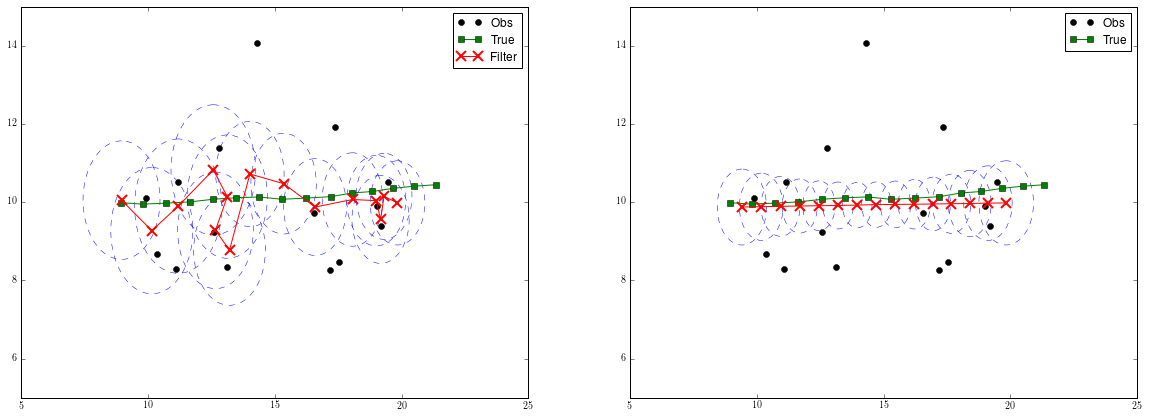

In [5]:
ss = 4    #Steady state space size
os = 2    #Observation size
A = np.array([[1, 0, 0.9, 0],[0, 1, 0, 0.9],[0, 0, 1, 0],[0, 0, 0, 1]])
C = np.array([[1, 0, 0, 0],[0, 1, 0, 0]])

Q = 0.001*np.eye(ss)
R = 1*np.eye(os)
initmu = np.array([8, 10, 1, 0])
initV = 1*np.eye(ss)

print("initmu: ",initmu.shape)
print("initV: ",initV.shape)
print("A: ",A.shape)
print("C: ",C.shape)
print("Q: ",Q.shape)
print("R: ",R.shape)
T = 15
x, y = ldsSample(A, C, Q, R, initmu, T)


input("Press enter to continue...")

mfilt, Vfilt, loglik, mpred, Vpred = kalmanFilter(y, A, C, Q, R, initmu, initV) #Calculated for plotting purposes

msmooth, Vsmooth, loglik, _ = kalmanSmoother(y, A, C, Q, R, initmu, initV)


#Draw Kalman filter estimates
fig, axes = plt.subplots(1,2)
fig.set_size_inches(20,7)
ax1 = axes[0]
ax2 = axes[1]
ax1.set_xlim(left=5,right=25)
ax1.set_ylim(bottom=5,top=15)
ax1.set_xlabel(r'$x_{1}$')
ax1.set_ylabel(r'$x_{2}$')
ax2.set_xlim(left=5,right=25)
ax2.set_ylim(bottom=5,top=15)
ax2.set_xlabel(r'$x_{1}$')
ax2.set_ylabel(r'$x_{2}$')

#Plot observations and true data
ax1.plot(y[0,:],y[1,:],'ko',label=r'Obs')  
ax1.plot(x[0,:],x[1,:],'g-s',label=r'True')


runTillEnd = False
#Plot Kalman filter estimate
for t in range(T):
    if not runTillEnd:
        if input("Press enter to continue (Predict). Type 'rte' to run simulation to end") == "rte":
            runTillEnd = True
     
    
    display.clear_output(wait=True)
    
    #Plot prediction
    plotGaussianEllipse(ax1, mpred[:,t], Vpred[:,:,t], \
                    ellipsecolor='green', markercolor='green')     
    display.display(fig)
    
    
    if not runTillEnd:
        if input("Press enter to continue (Obs). Type 'rte' to run simulation to end") == "rte":
            runTillEnd = True
     
    
    display.clear_output(wait=True)
    
    #Remove last prediction ellipse
    del ax1.patches[-1]
    del ax1.lines[-1]
        
    #Plot update
    if t == 0:
        plotGaussianEllipse(ax1, mfilt[:2,t],Vfilt[:2,:2,t],\
                    ellipsecolor='blue', markercolor='red',label=r'Filter')
        ax1.legend()
    else:
        plotGaussianEllipse(ax1, mfilt[:2,t],Vfilt[:2,:2,t],\
                    ellipsecolor='blue', markercolor='red',t=t)
    display.display(fig)

display.clear_output(wait=True)
ax1.legend()


#Plot observations and true data
ax2.plot(y[0,:],y[1,:],'ko',label=r'Obs')  
ax2.plot(x[0,:],x[1,:],'g-s',label=r'True')

#Redraw filtered estimates plot
for t in range(T):
    if t == 0:
        plotGaussianEllipse(ax2, mfilt[:2,t],Vfilt[:2,:2,t],\
                    ellipsecolor='blue', markercolor='red')
        ax1.legend()
    else:
        plotGaussianEllipse(ax2, mfilt[:2,t],Vfilt[:2,:2,t],\
                    ellipsecolor='blue', markercolor='red',t=t)


display.display(plt.gcf())


runTillEnd = False
for t in range(T-1,-1,-1):
 
    if not runTillEnd:
        if input("Press enter to continue (Obs). Type 'rte' to run simulation to end") == "rte":
            runTillEnd = True
    
    #Remove next filter estimate (moving left from t=15)
    del ax2.patches[-(T-t)]
        
    display.clear_output(wait=True)
    if t == 0:
        plotGaussianEllipse(ax2, msmooth[:2,t],Vsmooth[:2,:2,t],\
                            ellipsecolor='blue', markercolor='red',label=r'Smoothed',t=t)   #Plot new distr
    else:
        plotGaussianEllipse(ax2, msmooth[:2,t],Vsmooth[:2,:2,t],\
                            ellipsecolor='blue', markercolor='red',t=t)   #Plot new distr
    display.display(plt.gcf())
    
display.clear_output(wait=True)
ax2.legend()




---
#### 1.2.2 Time varying sinusoid

For this example we apply the Kalman smoother to simple sinusoidal signal. This example shows how the Kalman Smoother can work for more complicated types of signals.

In [6]:
def plotState(ax, t, x, var, alg,  markercolor, T=None, pred=None, label=None):
    """
        Plots a new point and the corresponding errorbar
        
        Args:
            ax - The Axes object on which to plot the ellipses
            t - Time point at which to plot
            x - Value of the state
            var - Variance of x
            markercolor - Centre marker colour
            alg - Indicates whether we are plotting for the Kalman filter or smoothing plot:
                    'KF' - Kalman Filter
                    'KS' - Kalman Smoother
            
          (Optional)
            T - Number of time points 
            pred - Indicates whether we are plotting for a prediction
            label - label for the plot containing this point
    """
    
    #Either plot points that are joined by a line or plot them individually
    if t > 0 and not pred:
        
        data = ax.lines[-1].get_data()
       
        if alg == 'KF':     #Filter plot
            
            if t > 1:
                del ax.collections[-1]   #Delete previous error fill
            
            sd = np.sqrt(var)    #Standard deviation
            
            #Update data for each object returned by the previous ax.errorbar(...)
            ax.fill_between(np.arange(t+1), x-sd, x+sd, alpha=0.2, color=markercolor, interpolate=True)
            new_xdata = np.append(data[0], t)
            new_ydata = np.append(data[1], x[-1])
            ax.lines[-1].set_data((new_xdata, new_ydata))
        else:  # alg == 'KS'
            if t < T-1:
                del ax.collections[-2:]   #Delete previous KF and KS error fills
            else:
                del ax.collections[-1]    #Only delete previous KF error fill
            
            msmooth = x[0]
            sdsmooth = np.sqrt(var[0])
            mfilt = x[1]
            sdfilt = np.sqrt(var[1])
            
            #Plot new smoothed estimate and error fill
            ax.fill_between(np.arange(t,T), msmooth-sdsmooth, msmooth+sdsmooth, alpha=0.2, \
                            color=markercolor, interpolate=True)
            data[0][t] = t
            data[1][t] = msmooth[0]
            ax.lines[-1].set_data((data[0],data[1]))
            
            #Re-plot filter estimate up till time t
            ax.fill_between(np.arange(t+1), mfilt-sdfilt, mfilt+sdfilt, alpha=0.2,\
                            color='red', interpolate=True)
               
    else:
        if pred:
            sd = np.sqrt(var)    #Standard deviation
            ax.errorbar(t,x,yerr=sd,fmt='x-',ms=10,mew=2,label=label,color=markercolor)
        else:
            if alg == 'KF':
                ax.plot(t,x,'x-',ms=10,mew=2,label=label,color=markercolor)
            else:  #alg == 'KS'
                del ax.collections[-2:]
                sd = np.sqrt(var)
                ax.fill_between(np.arange(t,T), x-sd, x+sd, alpha=0.2, \
                            color=markercolor, interpolate=True)
                data = ax.lines[-1].get_data()
                data[0][t] = t
                data[1][t] = x[0]
                ax.lines[-1].set_data((data[0],data[1]))
                
                
        

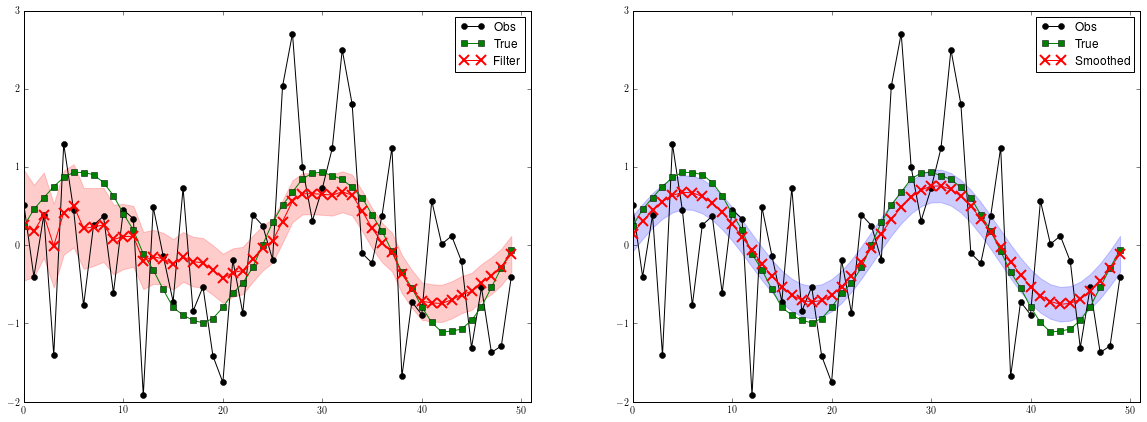

In [7]:
ss = 2    #Steady state space size
os = 1    #Observation size
dt = 0.25  #Change in time between samples
A = np.array([[math.cos(dt),math.sin(dt)],[-math.sin(dt),math.cos(dt)]])
C = np.array([[1, 0]])

Q = 0.001*np.eye(ss)
R = 1*np.eye(os)
initmu = np.array([0, 1])
initV = 1*np.eye(ss)

print("initmu: ",initmu.shape)
print("initV: ",initV.shape)
print("A: ",A.shape)
print("C: ",C.shape)
print("Q: ",Q.shape)
print("R: ",R.shape)
T = 50
x, y = ldsSample(A, C, Q, R, initmu, T)

input("Press enter to continue...")

mfilt, Vfilt, loglik, mpred, Vpred = kalmanFilter(y, A, C, Q, R, initmu, initV)

msmooth, Vsmooth, loglik, _ = kalmanSmoother(y, A, C, Q, R, initmu, initV)


#Draw Kalman filter estimates
fig, axes = plt.subplots(1,2)
fig.set_size_inches(20,7)
ax1 = axes[0]
ax2 = axes[1]
ax1.set_xlim(left=0,right=T+1)
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$y$')
ax2.set_xlim(left=0,right=T+1)
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$y$')

#Plot observations and true data
ax1.plot(y[0,:],'k-o',label=r'Obs')  
ax1.plot(x[0,:],'g-s',label=r'True')

display.display(plt.gcf())
input("Press enter to continue...")
runTillEnd = False

#Plot Kalman filter estimate
for t in range(T):

    if not runTillEnd:
        if input("Press enter to continue (Predict). Type 'rte' to run simulation to end") == "rte":
            runTillEnd = True
     
    #Plot prediction
    display.clear_output(wait=True)
    plotState(ax1, t, mpred[0,t], Vpred[0,0,t], 'KF', pred=True, markercolor='blue')     
    display.display(fig)
    
    
    if not runTillEnd:
        if input("Press enter to continue (Obs). Type 'rte' to run simulation to end") == "rte":
            runTillEnd = True
     
    
    #Remove last prediction plot
    del ax1.lines[-3:]
    del ax1.collections[-1]
    
    #Plot update
    display.clear_output(wait=True)
    if t == 0:
        plotState(ax1, t, mfilt[0,t], Vfilt[0,0,t], 'KF',markercolor='red',label=r'Filter')
        ax1.legend()
    else:
        plotState(ax1, t, mfilt[0,:t+1], Vfilt[0,0,:t+1], 'KF',markercolor='red')
    display.display(fig)
        
ax1.legend()
display.clear_output(wait=True)


#Plot observations and true data
ax2.plot(y[0,:],'k-o',label=r'Obs')  
ax2.plot(x[0,:],'g-s',label=r'True')

#Redraw filtered estimates plot
for t in range(T):
    if t == 0:
        plotState(ax2, t, mfilt[0,t],Vfilt[0,0,t], 'KF',markercolor='red')
        ax2.legend()
    else:
        plotState(ax2, t, mfilt[0,:t+1],Vfilt[0,0,:t+1], 'KF',markercolor='red')

display.display(plt.gcf())


runTillEnd = False
for t in range(T-1,-1,-1):
 
    if not runTillEnd:
        if input("Press enter to continue. Type 'rte' to run simulation to end") == "rte":
            runTillEnd = True
            
    display.clear_output(wait=True)
    if t == 0:
        plotState(ax2, t, msmooth[0,:], Vsmooth[0,0,:], 'KS',T=T,markercolor='blue') 
    else:
        plotState(ax2, t, np.array([msmooth[0,t:], mfilt[0,:t+1]]), np.array([Vsmooth[0,0,t:], Vfilt[0,0,:t+1]]),\
                  'KS',T=T,markercolor='blue')
    display.display(plt.gcf())

display.clear_output(wait=True)

# We have to add 'Smoothed' label manually
handles, labels = ax2.get_legend_handles_labels()
handles.append(ax2.lines[-1])
labels.append(u'Smoothed')
ax2.legend(handles, labels)
